In [1]:
import math
import sys
import os
from collections import defaultdict
from itertools import combinations

import numpy as np
from scipy.io import wavfile
from scipy import signal
import pandas as pd

import tensorflow as tf
from keras import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.models import load_model

from training import create_model, evaluate_model

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

import pyroomacoustics as pra
from pyroomacoustics.utilities import normalize
from pyroomacoustics.transform import stft

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler

from joblib import dump, load

%matplotlib inline

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 22, 10

In [2]:
# Label resolution of classification
RESOLUTION = 1

# Number of samples to include while creating one ML feature
SAMPLES = 2048

# Determines the overlap of samples between consecutive features
STEP = 8192

# Training rooms dimensions
ROOMS = {
    'small' : np.array([4, 4, 3]),
    'medium' : np.array([6, 6, 3]),
    'large' : np.array([8, 8, 3])
}

# Testing rooms dimensions
TEST_ROOMS = {
    'small' : np.array([5, 5, 2]),
    'medium' : np.array([7, 7, 2]),
    'large' : np.array([9, 9, 2])
}

AUDIO_PATH = '../training_data/audio'

# Number of microphones on the array
MICS_NUMBER = 6

MIC_COMBS = len(list(combinations(range(MICS_NUMBER), 2)))

In [8]:
def create_simulation_room(room_dim=[4, 4, 3], mic_pos=[2, 2, 1.5], room_fs=16000):
    """
    Utility function to create a shoebox room,
    with a microphone array included.
    """
    
    # Initialize room
    room = pra.ShoeBox(room_dim, fs=room_fs)

    # Declare microphone array position
    mic_center = mic_pos[:2]
    mic_height = mic_pos[-1]
    
    # Radius constant, will always be the same for MiniDSP array
    mic_radius = 0.045

    # Generate the microphone array
    mic_array_2D = pra.circular_2D_array(center=mic_center, M=6, phi0=0, radius=mic_radius)
    mic_array_3D = np.vstack((mic_array_2D, [mic_height] * 6))
    
    # Add the microphone array to room
    room.add_microphone_array(mic_array_3D)
    
    return room


def create_sound_sources(room_dim=[4, 4, 3], resolution=1, plane='horizontal'):
    """
    Function that creates a list of all audio source,
    that will be placed inside the room for simulation.
    """
    
    wall_len = room_dim[0] / 2
    
    #Specify angle in distance ranges
    angle_range = range(0, 360, resolution)
    dist_range = np.linspace(0.5, wall_len, 3)
    height_range = np.linspace(0, room_dim[-1], 3)
   
    sources = defaultdict(list)

    if plane == 'horizontal':
        for angle in angle_range:
            for R in dist_range:
                for h in height_range:
                    source = [R * math.cos(math.radians(angle)) + wall_len, 
                              R * math.sin(math.radians(angle)) + wall_len, h]
                    sources[angle].append((R, h, source))
                
    else:
        sources = create_sources_for_elevation(angle_range, room_dim, resolution)

    return sources


def create_sources_for_elevation(angle_range, room_dim=[4, 4, 3], resolution=1):
    """
    Helper function that creates spherically placed sources
    in order to have examples of different elevations of arrival.
    """
    
    sources = defaultdict(list)
    
    radius_range = np.linspace(0.5, room_dim[2] / 2, 3)
    elevation_range = range(0, 91, 10)
    
    wall_len = room_dim[0] / 2
    wall_height = room_dim[2] / 2
    
    for angle in angle_range:
        for R in radius_range:
            for elevation in elevation_range:
                h =  R * math.sin(math.radians(elevation)) + wall_height
                r = R * math.cos(math.radians(elevation))
                source = [r * math.cos(math.radians(angle)) + wall_len, 
                          r * math.sin(math.radians(angle)) + wall_len, h]
                sources[elevation].append((R, h, source))
                
    return sources


def simulate_room(audio_file, subset, room_type='small', mic_pos=[2, 2, 1.5], snr=None):
    """
    Function to simulate room with specified dimensions and microphone array position.
    Generates CSV files for all angle/distance combinations.
    
    Returns: a dictionary with all dataframes that were created.
    Keys are in a form of (angle, distance) tuples
    """
    
    file_name = os.path.basename(audio_file).split('.')[0]
    
    # Read the audio file
    fs, audio = wavfile.read(audio_file)
    
    # Get room dimensions
    if subset == 'train':
        room_dim = ROOMS[room_type]
    else:
        room_dim = TEST_ROOMS[room_type]
    
    # Create all sound sources
    plane = 'horizontal'
    sources = create_sound_sources(room_dim, 1, plane)
    label_res = 60
    # Simulate every sound source that was created before
    for angle, sources in sources.items():
        if angle % label_res == 0:
            print(f'Simulating {angle}-{angle + label_res - 1} degrees:', end=' ')
            
        sys.stdout.write("#")
        
        wav_signals = defaultdict(list)
        
        for dist, height, source in sources:
            room = create_simulation_room(room_dim=room_dim, mic_pos=mic_pos, room_fs=fs)
            room.add_source(source, signal=audio, delay=0.0)
            room.simulate(snr=snr)

            # Extract simulated signal for each microphone
            data = room.mic_array.signals.T
            data = np.array(normalize(data, bits=16), dtype=np.int16)
            
            # Append simulated data to the final WAV signals
            wav_signals[dist].extend(data)
            
        # Save WAV files containing 6 channel data for all distances at given angle
        for dist in wav_signals:
            save_name = f'{subset}_angle_{angle}_dist_{int(dist*100)}_room_{room_type}_snr_{snr}_{file_name}.wav'
            wavfile.write(f'{AUDIO_PATH}/{plane}/snr/{save_name}', fs, np.array(wav_signals[dist]))
        
        if angle % label_res == label_res - 1:
            print(' Done.')
            
    print('Simulation successful!')

## SNR

In [ ]:
training_sounds = os.listdir('../sounds/training')

print('\nSimulating training data:\n')
for sound in training_sounds:
    for room, dim in ROOMS.items():
        for snr in [10, 20, 40]:
            # Call the function above and store all results
            print('Audio file: ' + sound)
            print(f'Room: {room}')
            print(f'SNR: {snr}')
            simulate_room(f'../sounds/training/{sound}', 'train', room, dim / 2, snr)

            
            
testing_sounds = os.listdir('../sounds/testing')

print('\nSimulating testing data:\n')
for sound in testing_sounds:
    for room, dim in TEST_ROOMS.items():
        for snr in [10, 20, 40]:
            # Call the function above and store all results
            print('Audio file: ' + sound)
            print(f'Room: {room}')
            print(f'SNR: {snr}')
            simulate_room(f'../sounds/testing/{sound}', 'test', room, dim / 2, snr)

In [67]:
def gcc_phat(x_1, x_2, FS=16000, interp=1):
    """
    Function that will compute the GCC-PHAT
    cross-correlation of two separate audio channels
    
    Returns:
        A 1-D GCC vector
    """
    
    n = len(x_1) + len(x_2) - 1
    n += 1 if n % 2 else 0
    
    # Fourier transforms of the two signals
    X_1 = np.fft.rfft(x_1, n=n)
    X_2 = np.fft.rfft(x_2, n=n)
    
     # Normalize by the magnitude of FFT - because PHAT
    np.divide(X_1, np.abs(X_1), X_1, where=np.abs(X_1) != 0)
    np.divide(X_2, np.abs(X_2), X_2, where=np.abs(X_2) != 0)
    
    # GCC-PHAT = [X_1(f)X_2*(f)] / |X_1(f)X_2*(f)|
    # See http://www.xavieranguera.com/phdthesis/node92.html for reference
    CC = X_1 * np.conj(X_2)
    cc = np.fft.irfft(CC, n=n * interp)
        
    # Maximum delay between a pair of microphones,
    # expressed in a number of samples.
    # 0.09 m is the mic array diameter and 
    # 340 m/s is assumed to be the speed of sound.
    max_len = math.ceil(0.09 / 340 * FS * interp)
    
    # Trim the cc vector to only include a 
    # small number of samples around the origin
    cc = np.concatenate((cc[-max_len:], cc[:max_len+1]))
    
    # Return the cross correlation
    return cc


def compute_gcc_matrix(observation, fs, interp=1):
    """
    Creates a GCC matrix, where each row is a vector of GCC 
    between a given pair of microphones.
    """ 
    
    mic_pairs = combinations(range(MICS_NUMBER), r=2)

    # Initialize a transformed observation, that will be populated with GCC vectors
    # of the observation
    transformed_observation = []

    # Compute GCC for every pair of microphones
    for mic_1, mic_2 in mic_pairs:
        x_1 = observation[:, mic_1]
        x_2 = observation[:, mic_2]

        gcc = gcc_phat(x_1, x_2, FS=fs, interp=interp)

        # Add the GCC vector to the GCC matrix
        transformed_observation.append(gcc)    
        
    return transformed_observation


def compute_stft_matrix(observation, nfft=256):
    """
    Creates a STFT matrix using microphone data from 6 channels.
    """
    
    # Default value for overlap
    step = nfft // 2
    
    # Calculate multidimensional STFT and return
    transformed_observation = stft.analysis(observation, L=nfft, hop=step)
    return np.transpose(transformed_observation, axes=[2, 1, 0])


def create_observations(wav_signals, fs, label, samples=1, step=1, resolution=20, music=False, interp=1):
    """
    Create list of observations from the pandas dataframe.
    Each observation will be a GCC matrix, where each row 
    is a vector of GCC between a given pair of microphones.
    
    Returns: 
        a tuple of observations and their corresponding labels
    """
    
    # Lists of observations and labels that will be populated
    X = []
    y = []
    
    rounded_label = round(label / resolution) * resolution
    if rounded_label == 360: rounded_label = 0
    
    # Loop through the signal frame and take subframes
    for i in range(0, len(wav_signals) - samples + 1, step):
        y.append(rounded_label)
        
        # Extract the observation from subframe
        observation = np.array(wav_signals[i : i + samples])
        
        if music:
            # Transform observation into a STFT matrix
            transformed_observation = compute_stft_matrix(observation)
        else:
            # Transform observation into a GCC matrix
            transformed_observation = compute_gcc_matrix(observation, fs, interp=interp)
            
        X.append(transformed_observation)

    return X, y


def one_hot_encode(encoder, y_train, y_test):
    """
    Creates a one-hot encoding of categorical labels
    provided in y_train and y_test.
    """
    
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    
    # One-hot encode training and testing labels
    enc = encoder.fit(y_train)
    y_train = enc.transform(y_train)
    y_test = enc.transform(y_test)
    
    return y_train, y_test
  
    
def create_whole_dataset(df_train, df_test, encoder, room=None, dist=None):
    """
    Creates an entire dataset by extracting values
    from train and tests dataframes.
    
    One-hot encodes the labels before returning.
    """
    
    # Can filter testing entries to only check performance
    # for given conditions
    if room:
        df_test = df_test[df_test.room == room]
    if dist:
        df_test = df_test[df_test.dist == dist]
    
    # Create train/test observations
    X_train = df_train.drop(columns=['dist', 'room', 'label']).values.reshape(
        len(df_train), MIC_COMBS, -1)
    X_test = df_test.drop(columns=['dist', 'room', 'label']).values.reshape(
        len(df_test), MIC_COMBS, -1)
    
    # Create train/test labels
    y_train, y_test = one_hot_encode(
        encoder, df_train['label'].values, df_test['label'].values)
    
    return X_train, y_train, X_test, y_test


def create_dataframe(subset, plane='horizontal', samples=20, step=5, resolution=20, interp=1, snr=20):
    dataframes = []
    
    files = [file for file in os.listdir(os.path.join(AUDIO_PATH, plane, 'snr')) if subset in file and f'snr_{snr}' in file]

    # Loop through all WAVs
    for i, file in enumerate(files):
        if file[-3:] != 'wav': 
            continue
            
        print(f'{subset} file {i+1}/{len(files)}', end='\r')

        path = os.path.join(AUDIO_PATH, plane, 'snr', file)
        fs, wav_signals = wavfile.read(path)
        
        label = int(file.split('_')[2])
        
        # Create observations from a given WAV file
        X_temp, y_temp = create_observations(wav_signals, fs, label, samples, step, resolution, interp=interp)
        
        cols = [
            f'mics{mic_1+1}{mic_2+1}_{i}' 
                for mic_1, mic_2 in combinations(range(MICS_NUMBER), r=2) 
                    for i in range(np.shape(X_temp)[2])
        ]
        
        df = pd.DataFrame(data=np.reshape(X_temp, (len(X_temp), -1)), columns=cols)
        dist = int(file.split('_')[4])
        room = file.split('_')[6]
        df['dist'], df['room'] = dist, room
            
        # Add label column
        df['label'] = y_temp
        dataframes.append(df)
        
    return pd.concat(dataframes, ignore_index=True)

In [5]:
def evaluate_for_property(df_train, df_test, prop, value):
    """
    Measures the model prediction for test samples
    with a given property, such as room size.
    """
    
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    
    # Filter test set by property value
    X_trn, y_trn, X_tst, y_tst = create_whole_dataset(
        df_train, df_test[df_test[prop]==value], encoder
    )
    
    # Evaluate the model on the filtered set
    X_tst = np.transpose(X_tst, axes=[0, 2, 1])
    loss, acc = model.evaluate(X_tst, y_tst, batch_size=batch_size, verbose=0)
    
    return round(loss, 3), round(acc, 3)


def rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    total = sum(min(abs(y_t - y_p), (360 - abs(y_t - y_p))) ** 2 for y_t, y_p in zip(y_true, y_pred))
    rms = ((total / len(y_true)) ** 0.5)
    
    if type(rms) == np.ndarray:
        rms = rms[0]
        
    return round(rms, 3)

### Get model

In [79]:
epochs, batch_size, verbose = 10, 32, 1
model = load_model("../models/best_super_model")
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 23, 64)            2944      
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 21, 64)            12352     
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 19, 64)            12352     
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 17, 64)            12352     
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 15, 64)            12352     
_________________________________________________________________
dropout_8 (Dropout)          (None, 15, 64)            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 960)              

### SNR 20 dB

In [24]:
df_train = create_dataframe('train', samples=SAMPLES, step=STEP, resolution=RESOLUTION, interp=2, snr=20)
print()
df_test = create_dataframe('test', samples=SAMPLES, step=STEP, resolution=RESOLUTION, interp=2, snr=20)
print()

df_train.to_csv('../training_data/snr_20_azimuth_train_dataset.csv')
df_test.to_csv('../training_data/snr_20_azimuth_test_dataset.csv')

train file 3240/3240
test file 3240/3240


Run if dataframe is not loaded to memory

In [65]:
df_train = pd.read_csv('../training_data/snr_20_azimuth_train_dataset.csv', index_col=[0])
df_test = pd.read_csv('../training_data/snr_20_azimuth_test_dataset.csv', index_col=[0])

In [68]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder.fit([[label] for label in df_train['label']])
X_train, y_train, X_test, y_test = create_whole_dataset(df_train, df_test, encoder)
np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test)

((81000, 15, 25), (28800, 15, 25), (81000, 360), (28800, 360))

In [33]:
def plot_gccs(angle_labels, observations):
    # Create a 2x2 subplot
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    fig.suptitle('Example GCC matrices for different angles', fontsize=18)

    for i, label in enumerate(np.unique(angle_labels)[::90]):
        ax = axs[i//2][i%2]
        indices = np.where(angle_labels == label)[0]
        obs_idx = indices[np.random.randint(len(indices))]

        observation = observations[obs_idx]

        ax.set_title(f'Angle {label}')
        im = ax.matshow(observation.T, aspect=0.5)
        fig.colorbar(im, ax=ax)

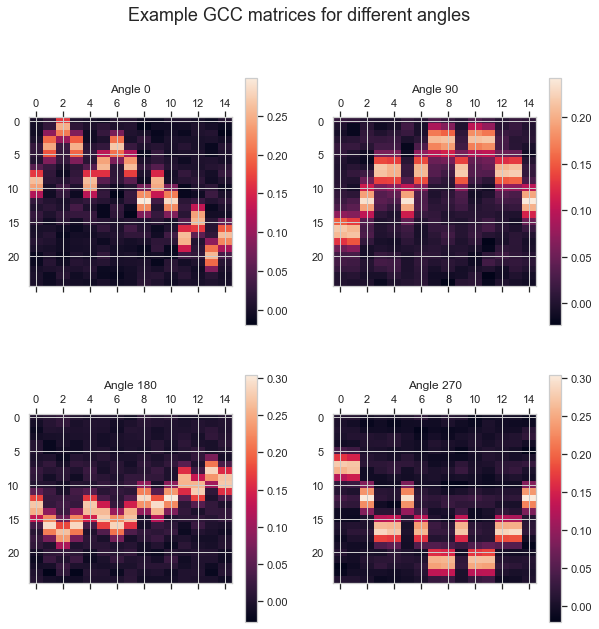

In [101]:
# Get training labels
angle_labels = encoder.inverse_transform(y_test)
plot_gccs(angle_labels, X_test)

In [69]:
# Transpose the observations because Conv1D requires timesteps as the 1st dim
if X_train.shape[1] == MIC_COMBS:
    X_train, X_test = np.transpose(X_train, axes=[0, 2, 1]), np.transpose(X_test, axes=[0, 2, 1])
X_train.shape, X_test.shape

((81000, 25, 15), (28800, 25, 15))

In [70]:
model = load_model("../models/best_super_model")
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/10
2532/2532 [==============================] - 15s 6ms/step - loss: 1.2276 - accuracy: 0.6095
Epoch 2/10
2532/2532 [==============================] - 15s 6ms/step - loss: 1.1012 - accuracy: 0.6305
Epoch 3/10
2532/2532 [==============================] - 15s 6ms/step - loss: 1.0610 - accuracy: 0.6408
Epoch 4/10
2532/2532 [==============================] - 15s 6ms/step - loss: 1.0361 - accuracy: 0.6458
Epoch 5/10
2532/2532 [==============================] - 15s 6ms/step - loss: 1.0199 - accuracy: 0.6501
Epoch 6/10
2532/2532 [==============================] - 15s 6ms/step - loss: 1.0066 - accuracy: 0.6551
Epoch 7/10
2532/2532 [==============================] - 15s 6ms/step - loss: 0.9955 - accuracy: 0.6583
Epoch 8/10
2532/2532 [==============================] - 15s 6ms/step - loss: 0.9892 - accuracy: 0.6584
Epoch 9/10
2532/2532 [==============================] - 15s 6ms/step - loss: 0.9828 - accuracy: 0.6618
Epoch 10/10
2532/2532 [==============================] - 15s 6ms/step - l

In [71]:
# Test model
accuracy = evaluate_model(model, X_test, y_test)
print(f'Accuracy: {accuracy}')
y_pred_nn = encoder.inverse_transform(model.predict(X_test))
y_true_nn = encoder.inverse_transform(y_test)
print(f'RMSE: {rmse(y_true_nn, y_pred_nn)}')

900/900 [==============================] - 3s 3ms/step - loss: 0.6749 - accuracy: 0.7268
Accuracy: 0.727
RMSE: 4.478


In [77]:
# Evaluate performance for different properties
print('Room sizes')
for room in ROOMS:
    _, acc = evaluate_for_property(df_train, df_test, 'room', room)
    print(f"{room} room accuracy: {acc}")
    
print('\nDistances')
for dist in np.unique(df_test.dist):
    _, acc = evaluate_for_property(df_train, df_test, 'dist', dist)
    print(f"{dist} cm distance accuracy: {acc}")

Room sizes
small room accuracy: 0.718
medium room accuracy: 0.728
large room accuracy: 0.742

Distances
50 cm distance accuracy: 0.567
150 cm distance accuracy: 0.795
200 cm distance accuracy: 0.836
250 cm distance accuracy: 0.803
350 cm distance accuracy: 0.79
450 cm distance accuracy: 0.817


#### Evaluate the retrained model on the ENTIRE dataset

In [75]:
df_train_all = pd.read_csv('../training_data/super_azimuth_train_dataset.csv', index_col=[0])
df_test_all = pd.read_csv('../training_data/super_azimuth_test_dataset.csv', index_col=[0])

df_train_all = pd.concat([df_train, df_train_all], ignore_index=True)
df_test_all = pd.concat([df_test, df_test_all], ignore_index=True)

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder.fit([[label] for label in df_train_all['label']])
X_train, y_train, X_test, y_test = create_whole_dataset(df_train_all, df_test_all, encoder)
np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test)

((709560, 15, 25), (239540, 15, 25), (709560, 360), (239540, 360))

In [77]:
# Transpose the observations because Conv1D requires timesteps as the 1st dim
if X_train.shape[1] == MIC_COMBS:
    X_train, X_test = np.transpose(X_train, axes=[0, 2, 1]), np.transpose(X_test, axes=[0, 2, 1])
X_train.shape, X_test.shape

((709560, 25, 15), (239540, 25, 15))

In [78]:
# Test model
accuracy = evaluate_model(model, X_test, y_test)
print(f'Accuracy: {accuracy}')
y_pred_nn = encoder.inverse_transform(model.predict(X_test))
y_true_nn = encoder.inverse_transform(y_test)
print(f'RMSE: {rmse(y_true_nn, y_pred_nn)}')

7486/7486 [==============================] - 32s 4ms/step - loss: 0.8217 - accuracy: 0.7787
Accuracy: 0.779
RMSE: 7.334


### SNR 10 dB

In [20]:
df_train = create_dataframe('train', samples=SAMPLES, step=STEP, resolution=RESOLUTION, interp=2, snr=10)
print()
df_test = create_dataframe('test', samples=SAMPLES, step=STEP, resolution=RESOLUTION, interp=2, snr=10)
print()

df_train.to_csv('../training_data/snr_10_azimuth_train_dataset.csv')
df_test.to_csv('../training_data/snr_10_azimuth_test_dataset.csv')

train file 3240/3240
test file 3240/3240


In [60]:
df_train = pd.read_csv('../training_data/snr_10_azimuth_train_dataset.csv', index_col=[0])
df_test = pd.read_csv('../training_data/snr_10_azimuth_test_dataset.csv', index_col=[0])

In [61]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder.fit([[label] for label in df_train['label']])
X_train, y_train, X_test, y_test = create_whole_dataset(df_train, df_test, encoder)
np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test)

((81000, 15, 25), (28800, 15, 25), (81000, 360), (28800, 360))

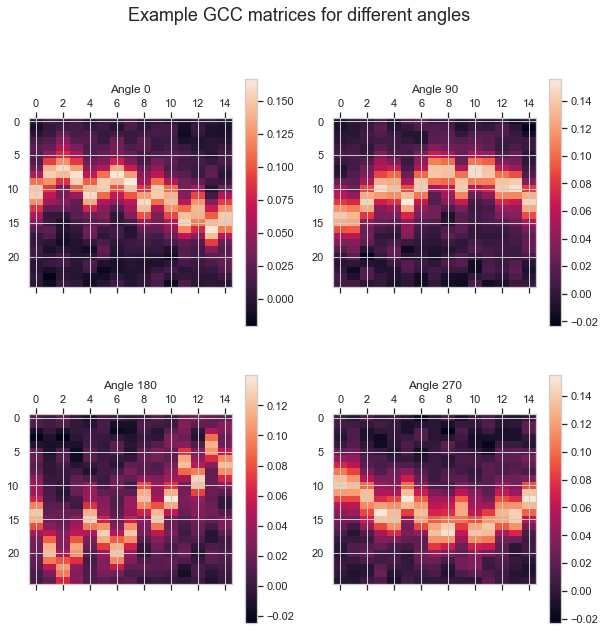

In [73]:
# Get training labels
angle_labels = encoder.inverse_transform(y_test)
plot_gccs(angle_labels, X_test)

In [62]:
# Transpose the observations because Conv1D requires timesteps as the 1st dim
if X_train.shape[1] == MIC_COMBS:
    X_train, X_test = np.transpose(X_train, axes=[0, 2, 1]), np.transpose(X_test, axes=[0, 2, 1])
X_train.shape, X_test.shape

((81000, 25, 15), (28800, 25, 15))

In [63]:
model = load_model("../models/best_super_model")
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/10
2532/2532 [==============================] - 15s 6ms/step - loss: 2.5504 - accuracy: 0.2624
Epoch 2/10
2532/2532 [==============================] - 14s 6ms/step - loss: 2.1582 - accuracy: 0.2995
Epoch 3/10
2532/2532 [==============================] - 14s 6ms/step - loss: 2.0604 - accuracy: 0.3117
Epoch 4/10
2532/2532 [==============================] - 14s 5ms/step - loss: 1.9951 - accuracy: 0.3220
Epoch 5/10
2532/2532 [==============================] - 14s 6ms/step - loss: 1.9559 - accuracy: 0.3295
Epoch 6/10
2532/2532 [==============================] - 14s 6ms/step - loss: 1.9277 - accuracy: 0.3314
Epoch 7/10
2532/2532 [==============================] - 14s 6ms/step - loss: 1.8989 - accuracy: 0.3405
Epoch 8/10
2532/2532 [==============================] - 14s 6ms/step - loss: 1.8824 - accuracy: 0.3435
Epoch 9/10
2532/2532 [==============================] - 15s 6ms/step - loss: 1.8655 - accuracy: 0.3461
Epoch 10/10
2532/2532 [==============================] - 18s 7ms/step - l

In [64]:
# Test model
accuracy = evaluate_model(model, X_test, y_test)
print(f'Accuracy: {accuracy}')
y_pred_nn = encoder.inverse_transform(model.predict(X_test))
y_true_nn = encoder.inverse_transform(y_test)
print(f'RMSE: {rmse(y_true_nn, y_pred_nn)}')

900/900 [==============================] - 3s 3ms/step - loss: 1.4059 - accuracy: 0.4019
Accuracy: 0.402
RMSE: 1.139


In [65]:
# Evaluate performance for different properties
print('Room sizes')
for room in ROOMS:
    _, acc = evaluate_for_property(df_train, df_test, 'room', room)
    print(f"{room} room accuracy: {acc}")
    
print('\nDistances')
for dist in np.unique(df_test.dist):
    _, acc = evaluate_for_property(df_train, df_test, 'dist', dist)
    print(f"{dist} cm distance accuracy: {acc}")

Room sizes
small room accuracy: 0.384
medium room accuracy: 0.407
large room accuracy: 0.414

Distances
50 cm distance accuracy: 0.325
150 cm distance accuracy: 0.419
200 cm distance accuracy: 0.467
250 cm distance accuracy: 0.435
350 cm distance accuracy: 0.428
450 cm distance accuracy: 0.449


### SNR 40 dB

In [21]:
df_train = create_dataframe('train', samples=SAMPLES, step=STEP, resolution=RESOLUTION, interp=2, snr=40)
print()
df_test = create_dataframe('test', samples=SAMPLES, step=STEP, resolution=RESOLUTION, interp=2, snr=40)
print()

df_train.to_csv('../training_data/snr_40_azimuth_train_dataset.csv')
df_test.to_csv('../training_data/snr_40_azimuth_test_dataset.csv')

train file 3240/3240
test file 3240/3240


In [66]:
df_train = pd.read_csv('../training_data/snr_40_azimuth_train_dataset.csv', index_col=[0])
df_test = pd.read_csv('../training_data/snr_40_azimuth_test_dataset.csv', index_col=[0])

In [67]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder.fit([[label] for label in df_train['label']])
X_train, y_train, X_test, y_test = create_whole_dataset(df_train, df_test, encoder)
np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test)

((81000, 15, 25), (28800, 15, 25), (81000, 360), (28800, 360))

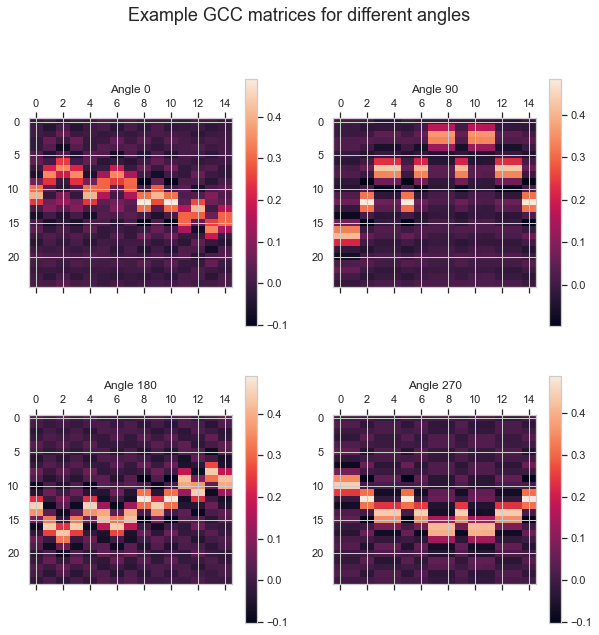

In [76]:
# Get training labels
angle_labels = encoder.inverse_transform(y_test)
plot_gccs(angle_labels, X_test)

In [68]:
# Transpose the observations because Conv1D requires timesteps as the 1st dim
if X_train.shape[1] == MIC_COMBS:
    X_train, X_test = np.transpose(X_train, axes=[0, 2, 1]), np.transpose(X_test, axes=[0, 2, 1])
X_train.shape, X_test.shape

((81000, 25, 15), (28800, 25, 15))

In [69]:
model = load_model("../models/best_super_model")
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/10
2532/2532 [==============================] - 15s 6ms/step - loss: 0.4935 - accuracy: 0.8680
Epoch 2/10
2532/2532 [==============================] - 14s 6ms/step - loss: 0.4862 - accuracy: 0.8693
Epoch 3/10
2532/2532 [==============================] - 15s 6ms/step - loss: 0.4763 - accuracy: 0.8726
Epoch 4/10
2532/2532 [==============================] - 15s 6ms/step - loss: 0.4742 - accuracy: 0.8737
Epoch 5/10
2532/2532 [==============================] - 14s 6ms/step - loss: 0.4678 - accuracy: 0.8761
Epoch 6/10
2532/2532 [==============================] - 14s 6ms/step - loss: 0.4652 - accuracy: 0.8765
Epoch 7/10
2532/2532 [==============================] - 14s 6ms/step - loss: 0.4649 - accuracy: 0.8772
Epoch 8/10
2532/2532 [==============================] - 14s 6ms/step - loss: 0.4626 - accuracy: 0.8777
Epoch 9/10
2532/2532 [==============================] - 14s 6ms/step - loss: 0.4646 - accuracy: 0.8772
Epoch 10/10
2532/2532 [==============================] - 14s 6ms/step - l

In [70]:
# Test model
accuracy = evaluate_model(model, X_test, y_test)
print(f'Accuracy: {accuracy}')
y_pred_nn = encoder.inverse_transform(model.predict(X_test))
y_true_nn = encoder.inverse_transform(y_test)
print(f'RMSE: {rmse(y_true_nn, y_pred_nn)}')

900/900 [==============================] - 2s 2ms/step - loss: 0.6193 - accuracy: 0.8584
Accuracy: 0.858
RMSE: 11.108


In [71]:
# Evaluate performance for different properties
print('Room sizes')
for room in ROOMS:
    _, acc = evaluate_for_property(df_train, df_test, 'room', room)
    print(f"{room} room accuracy: {acc}")
    
print('\nDistances')
for dist in np.unique(df_test.dist):
    _, acc = evaluate_for_property(df_train, df_test, 'dist', dist)
    print(f"{dist} cm distance accuracy: {acc}")

Room sizes
small room accuracy: 0.864
medium room accuracy: 0.853
large room accuracy: 0.859

Distances
50 cm distance accuracy: 0.671
150 cm distance accuracy: 0.967
200 cm distance accuracy: 0.966
250 cm distance accuracy: 0.948
350 cm distance accuracy: 0.931
450 cm distance accuracy: 0.932


### SNR 5 dB

In [79]:
df_test = create_dataframe('test', samples=SAMPLES, step=STEP, resolution=RESOLUTION, interp=2, snr=5)
print()
df_test.to_csv('../training_data/snr_5_azimuth_test_dataset.csv')

test file 3240/3240


In [118]:
df_test = pd.read_csv('../training_data/snr_5_azimuth_test_dataset.csv', index_col=[0])

In [ ]:
df_train = pd.read_csv('../training_data/super_azimuth_train_dataset.csv', index_col=[0])

In [119]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder.fit([[label] for label in df_train['label']])
X_train, y_train, X_test, y_test = create_whole_dataset(df_train, df_test, encoder)
np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test)

((628560, 15, 25), (210740, 15, 25), (628560, 360), (210740, 360))

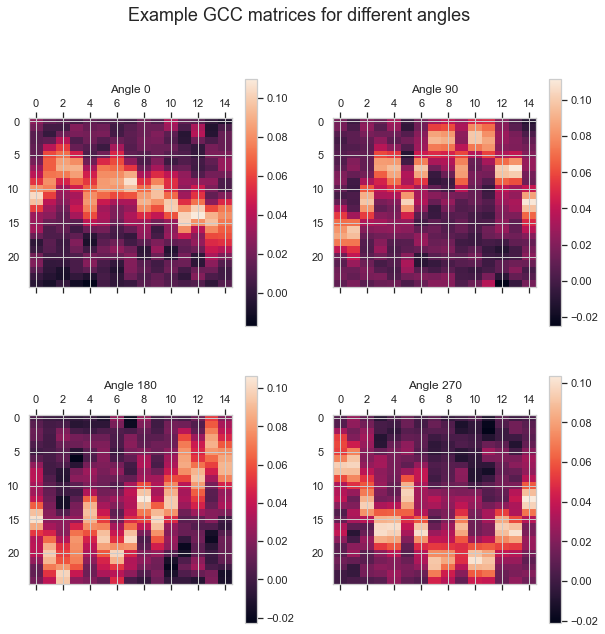

In [83]:
# Get training labels
angle_labels = encoder.inverse_transform(y_test)
plot_gccs(angle_labels, X_test)

In [ ]:
# Transpose the observations because Conv1D requires timesteps as the 1st dim
if X_train.shape[1] == MIC_COMBS:
    X_train, X_test = np.transpose(X_train, axes=[0, 2, 1]), np.transpose(X_test, axes=[0, 2, 1])
X_train.shape, X_test.shape

In [106]:
# Test model
accuracy = evaluate_model(model, X_test, y_test)
print(f'Accuracy: {accuracy}')
y_pred_nn = encoder.inverse_transform(model.predict(X_test))
y_true_nn = encoder.inverse_transform(y_test)
print(f'RMSE: {rmse(y_true_nn, y_pred_nn)}')

6586/6586 [==============================] - 27s 4ms/step - loss: 3.9067 - accuracy: 0.1133
Accuracy: 0.113
RMSE: 38.885


### Plot GCCs for different SNR

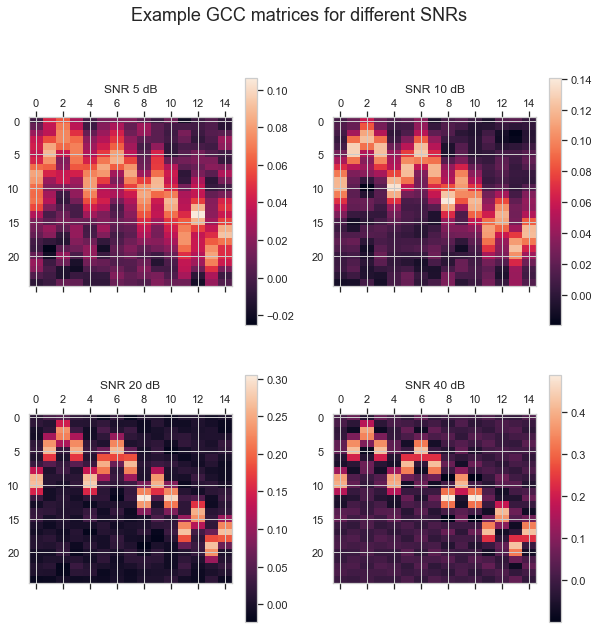

In [140]:
# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(10,10))
fig.suptitle('Example GCC matrices for different SNRs', fontsize=18)
labels = [5, 10, 20, 40]
for i, matrix in enumerate(GCCs):
    ax = axs[i//2][i%2]
    ax.set_title(f'SNR {labels[i]} dB')
    im = ax.matshow(matrix.T, aspect=0.5)
    fig.colorbar(im, ax=ax)

## RT60

In [17]:
def create_simulation_room(room_dim=[4, 4, 3], mic_pos=[2, 2, 1.5], room_fs=16000, rt60=None):
    """
    Utility function to create a shoebox room,
    with a microphone array included.
    """
    
    # Initialize room
    if rt60 is not None:
        e_absorption, max_order = pra.inverse_sabine(rt60, room_dim)
        room = pra.ShoeBox(room_dim, fs=room_fs, materials=pra.Material(e_absorption), max_order=max_order)
    else:
        room = pra.ShoeBox(room_dim, fs=room_fs)

    # Declare microphone array position
    mic_center = mic_pos[:2]
    mic_height = mic_pos[-1]
    
    # Radius constant, will always be the same for MiniDSP array
    mic_radius = 0.045

    # Generate the microphone array
    mic_array_2D = pra.circular_2D_array(center=mic_center, M=6, phi0=0, radius=mic_radius)
    mic_array_3D = np.vstack((mic_array_2D, [mic_height] * 6))
    
    # Add the microphone array to room
    room.add_microphone_array(mic_array_3D)
    
    return room


def create_sound_sources(room_dim=[4, 4, 3], resolution=1, plane='horizontal'):
    """
    Function that creates a list of all audio source,
    that will be placed inside the room for simulation.
    """
    
    wall_len = room_dim[0] / 2
    
    #Specify angle in distance ranges
    angle_range = range(0, 360, resolution)
    dist_range = np.linspace(0.5, wall_len, 3)
    height_range = np.linspace(0, room_dim[-1], 3)
   
    sources = defaultdict(list)

    if plane == 'horizontal':
        for angle in angle_range:
            for R in dist_range:
                for h in height_range:
                    source = [R * math.cos(math.radians(angle)) + wall_len, 
                              R * math.sin(math.radians(angle)) + wall_len, h]
                    sources[angle].append((R, h, source))
                
    else:
        sources = create_sources_for_elevation(angle_range, room_dim, resolution)

    return sources


def create_sources_for_elevation(angle_range, room_dim=[4, 4, 3], resolution=1):
    """
    Helper function that creates spherically placed sources
    in order to have examples of different elevations of arrival.
    """
    
    sources = defaultdict(list)
    
    radius_range = np.linspace(0.5, room_dim[2] / 2, 3)
    elevation_range = range(0, 91, 10)
    
    wall_len = room_dim[0] / 2
    wall_height = room_dim[2] / 2
    
    for angle in angle_range:
        for R in radius_range:
            for elevation in elevation_range:
                h =  R * math.sin(math.radians(elevation)) + wall_height
                r = R * math.cos(math.radians(elevation))
                source = [r * math.cos(math.radians(angle)) + wall_len, 
                          r * math.sin(math.radians(angle)) + wall_len, h]
                sources[elevation].append((R, h, source))
                
    return sources


def simulate_room(audio_file, subset, room_type='small', mic_pos=[2, 2, 1.5], snr=None, rt60=None):
    """
    Function to simulate room with specified dimensions and microphone array position.
    Generates CSV files for all angle/distance combinations.
    
    Returns: a dictionary with all dataframes that were created.
    Keys are in a form of (angle, distance) tuples
    """
    
    file_name = os.path.basename(audio_file).split('.')[0]
    
    # Read the audio file
    fs, audio = wavfile.read(audio_file)
    
    # Get room dimensions
    if subset == 'train':
        room_dim = ROOMS[room_type]
    else:
        room_dim = TEST_ROOMS[room_type]
    
    # Create all sound sources
    plane = 'horizontal'
    sources = create_sound_sources(room_dim, 1, plane)
    label_res = 60
    # Simulate every sound source that was created before
    for angle, sources in sources.items():
        if angle % label_res == 0:
            print(f'Simulating {angle}-{angle + label_res - 1} degrees:', end=' ')
            
        sys.stdout.write("#")
        
        wav_signals = defaultdict(list)
        
        for dist, height, source in sources:
            room = create_simulation_room(room_dim=room_dim, mic_pos=mic_pos, room_fs=fs, rt60=rt60)
            room.add_source(source, signal=audio, delay=0.0)
            room.simulate(snr=snr)

            # Extract simulated signal for each microphone
            data = room.mic_array.signals.T
            data = np.array(normalize(data, bits=16), dtype=np.int16)
            
            # Append simulated data to the final WAV signals
            wav_signals[dist].extend(data)
            
        # Save WAV files containing 6 channel data for all distances at given angle
        for dist in wav_signals:
            save_name = f'{subset}_angle_{angle}_dist_{int(dist*100)}_room_{room_type}_rt60_{int(rt60*1000)}_{file_name}.wav'
            wavfile.write(f'{AUDIO_PATH}/{plane}/rt60/{save_name}', fs, np.array(wav_signals[dist]))
        
        if angle % label_res == label_res - 1:
            print(' Done.')
            
    print('Simulation successful!')
    
    
def create_whole_dataset(df_train, df_test, encoder, room=None, dist=None):
    """
    Creates an entire dataset by extracting values
    from train and tests dataframes.
    
    One-hot encodes the labels before returning.
    """
    
    # Can filter testing entries to only check performance
    # for given conditions
    if room:
        df_test = df_test[df_test.room == room]
    if dist:
        df_test = df_test[df_test.dist == dist]
    
    # Create train/test observations
    X_train = df_train.drop(columns=['dist', 'room', 'label', 'rt60']).values.reshape(
        len(df_train), MIC_COMBS, -1)
    X_test = df_test.drop(columns=['dist', 'room', 'label', 'rt60']).values.reshape(
        len(df_test), MIC_COMBS, -1)
    
    # Create train/test labels
    y_train, y_test = one_hot_encode(
        encoder, df_train['label'].values, df_test['label'].values)
    
    return X_train, y_train, X_test, y_test
    

def create_dataframe(subset, plane='horizontal', samples=20, step=5, resolution=20, interp=1):
    dataframes = []
    
    files = [file for file in os.listdir(os.path.join(AUDIO_PATH, plane, 'rt60')) if subset in file]

    # Loop through all WAVs
    for i, file in enumerate(files):
        if file[-3:] != 'wav': 
            continue
            
        print(f'{subset} file {i+1}/{len(files)}', end='\r')

        path = os.path.join(AUDIO_PATH, plane, 'rt60', file)
        fs, wav_signals = wavfile.read(path)
        
        label = int(file.split('_')[2])
        
        # Create observations from a given WAV file
        X_temp, y_temp = create_observations(wav_signals, fs, label, samples, step, resolution, interp=interp)
        
        cols = [
            f'mics{mic_1+1}{mic_2+1}_{i}' 
                for mic_1, mic_2 in combinations(range(MICS_NUMBER), r=2) 
                    for i in range(np.shape(X_temp)[2])
        ]
        
        df = pd.DataFrame(data=np.reshape(X_temp, (len(X_temp), -1)), columns=cols)
        dist = int(file.split('_')[4])
        room = file.split('_')[6]
        rt60 = int(file.split('_')[8])
        df['dist'], df['room'] = dist, room
        df['rt60'] = rt60
            
        # Add label column
        df['label'] = y_temp
        dataframes.append(df)
        
    return pd.concat(dataframes, ignore_index=True)

In [ ]:
training_sounds = os.listdir('../sounds/training')

print('\nSimulating training data:\n')
for sound in training_sounds:
    for room, dim in ROOMS.items():
        for rt60 in [0.1, 0.3]:
            # Call the function above and store all results
            print('Audio file: ' + sound)
            print(f'Room: {room}')
            print(f'RT60: {rt60}')
            simulate_room(f'../sounds/training/{sound}', 'train', room, dim / 2, rt60=rt60)

            
            
testing_sounds = os.listdir('../sounds/testing')

print('\nSimulating testing data:\n')
for sound in testing_sounds:
    for room, dim in TEST_ROOMS.items():
        for rt60 in [0.1, 0.3]:
            # Call the function above and store all results
            print('Audio file: ' + sound)
            print(f'Room: {room}')
            print(f'RT60: {rt60}')
            simulate_room(f'../sounds/testing/{sound}', 'test', room, dim / 2, rt60=rt60)

### Prepare data

In [19]:
df_train = create_dataframe('train', samples=SAMPLES, step=STEP, resolution=RESOLUTION, interp=2)
print()
df_test = create_dataframe('test', samples=SAMPLES, step=STEP, resolution=RESOLUTION, interp=2)
print()

df_train.to_csv('../training_data/rt60_azimuth_train_dataset.csv')
df_test.to_csv('../training_data/rt60_azimuth_test_dataset.csv')

train file 2160/2160
test file 2160/2160


In [ ]:
df_train = pd.read_csv('../training_data/rt60_azimuth_train_dataset.csv', index_col=[0])
df_test = pd.read_csv('../training_data/rt60_azimuth_test_dataset.csv', index_col=[0])

### RT60 0.1 s

In [28]:
df_train.rt60 = pd.to_numeric(df_train.rt60)
df_test.rt60 = pd.to_numeric(df_test.rt60)

In [29]:
df_train_100 = df_train[df_train.rt60 == 100]
df_test_100 = df_test[df_test.rt60 == 100]

In [53]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder.fit([[label] for label in df_train['label']])
X_train, y_train, X_test, y_test = create_whole_dataset(df_train_100, df_test_100, encoder)
np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test)

((28080, 15, 25), (11516, 15, 25), (28080, 360), (11516, 360))

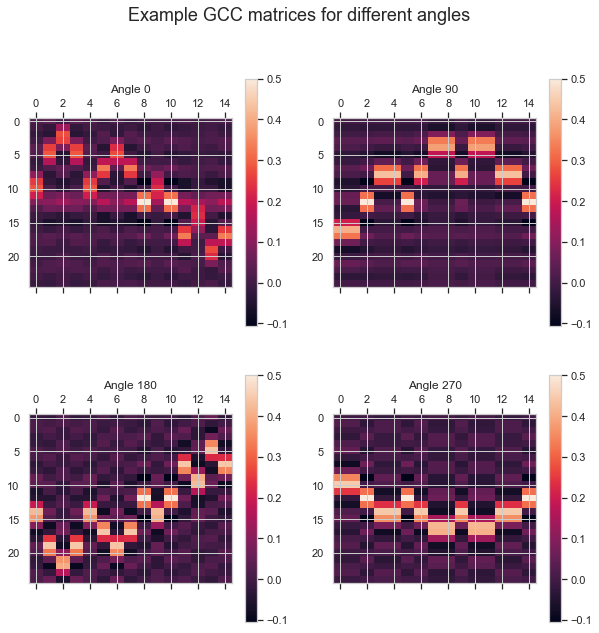

In [54]:
# Get training labels
angle_labels = encoder.inverse_transform(y_test)
plot_gccs(angle_labels, X_test)

In [55]:
# Transpose the observations because Conv1D requires timesteps as the 1st dim
if X_train.shape[1] == MIC_COMBS:
    X_train, X_test = np.transpose(X_train, axes=[0, 2, 1]), np.transpose(X_test, axes=[0, 2, 1])
X_train.shape, X_test.shape

((28080, 25, 15), (11516, 25, 15))

In [58]:
model = load_model("../models/best_super_model")
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/10
878/878 [==============================] - 13s 6ms/step - loss: 0.1964 - accuracy: 0.9325
Epoch 2/10
878/878 [==============================] - 5s 6ms/step - loss: 0.1768 - accuracy: 0.9399
Epoch 3/10
878/878 [==============================] - 5s 6ms/step - loss: 0.1695 - accuracy: 0.9424
Epoch 4/10
878/878 [==============================] - 5s 6ms/step - loss: 0.1592 - accuracy: 0.9467
Epoch 5/10
878/878 [==============================] - 5s 6ms/step - loss: 0.1573 - accuracy: 0.9478
Epoch 6/10
878/878 [==============================] - 5s 6ms/step - loss: 0.1462 - accuracy: 0.9516
Epoch 7/10
878/878 [==============================] - 5s 6ms/step - loss: 0.1518 - accuracy: 0.9486
Epoch 8/10
878/878 [==============================] - 5s 6ms/step - loss: 0.1572 - accuracy: 0.9482
Epoch 9/10
878/878 [==============================] - 5s 6ms/step - loss: 0.1521 - accuracy: 0.9491
Epoch 10/10
878/878 [==============================] - 5s 6ms/step - loss: 0.1498 - accuracy: 0.949

In [59]:
# Test model
accuracy = evaluate_model(model, X_test, y_test)
print(f'Accuracy: {accuracy}')
y_pred_nn = encoder.inverse_transform(model.predict(X_test))
y_true_nn = encoder.inverse_transform(y_test)
print(f'RMSE: {rmse(y_true_nn, y_pred_nn)}')

360/360 [==============================] - 2s 4ms/step - loss: 1.6645 - accuracy: 0.7296
Accuracy: 0.73
RMSE: 42.221


### RT60 0.3 s

In [36]:
df_train_300 = df_train[df_train.rt60 == 300]
df_test_300 = df_test[df_test.rt60 == 300]

In [60]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder.fit([[label] for label in df_train['label']])
X_train, y_train, X_test, y_test = create_whole_dataset(df_train_300, df_test_300, encoder)
np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test)

((30512, 15, 25), (16200, 15, 25), (30512, 360), (16200, 360))

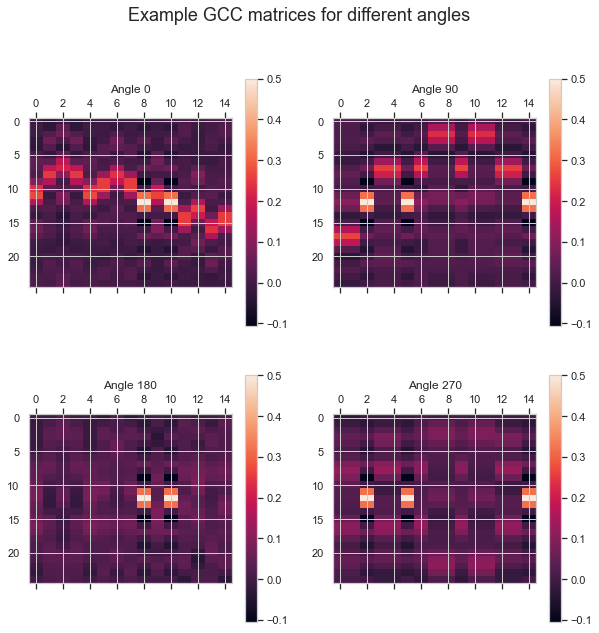

In [61]:
# Get training labels
angle_labels = encoder.inverse_transform(y_test)
plot_gccs(angle_labels, X_test)

In [62]:
# Transpose the observations because Conv1D requires timesteps as the 1st dim
if X_train.shape[1] == MIC_COMBS:
    X_train, X_test = np.transpose(X_train, axes=[0, 2, 1]), np.transpose(X_test, axes=[0, 2, 1])
X_train.shape, X_test.shape

((30512, 25, 15), (16200, 25, 15))

In [63]:
model = load_model("../models/best_super_model")
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/10
954/954 [==============================] - 6s 6ms/step - loss: 2.7147 - accuracy: 0.3145
Epoch 2/10
954/954 [==============================] - 6s 6ms/step - loss: 2.3358 - accuracy: 0.3611
Epoch 3/10
954/954 [==============================] - 6s 6ms/step - loss: 2.1879 - accuracy: 0.3900
Epoch 4/10
954/954 [==============================] - 6s 6ms/step - loss: 2.0933 - accuracy: 0.4049
Epoch 5/10
954/954 [==============================] - 6s 6ms/step - loss: 2.0185 - accuracy: 0.4229
Epoch 6/10
954/954 [==============================] - 6s 6ms/step - loss: 1.9619 - accuracy: 0.4396
Epoch 7/10
954/954 [==============================] - 6s 6ms/step - loss: 1.9066 - accuracy: 0.4462
Epoch 8/10
954/954 [==============================] - 6s 6ms/step - loss: 1.8675 - accuracy: 0.4614
Epoch 9/10
954/954 [==============================] - 6s 6ms/step - loss: 1.8441 - accuracy: 0.4682
Epoch 10/10
954/954 [==============================] - 6s 6ms/step - loss: 1.7957 - accuracy: 0.4810

In [64]:
# Test model
accuracy = evaluate_model(model, X_test, y_test)
print(f'Accuracy: {accuracy}')
y_pred_nn = encoder.inverse_transform(model.predict(X_test))
y_true_nn = encoder.inverse_transform(y_test)
print(f'RMSE: {rmse(y_true_nn, y_pred_nn)}')

507/507 [==============================] - 2s 4ms/step - loss: 3.4908 - accuracy: 0.2846
Accuracy: 0.285
RMSE: 65.964
